In [781]:
import pandas as pd

0.25.1


In [751]:
#read in accepted loan application file
accepted = "archive/accepted_2007_to_2018q4/accepted_2007_to_2018Q4.csv"
acceptedLoans = pd.read_csv(accepted)

MemoryError: 

In [753]:
#read in rejected loan application file
rejected = "archive/rejected_2007_to_2018q4/rejected_2007_to_2018Q4.csv"
rejectedLoans = pd.read_csv(rejected)

MemoryError: 

In [755]:
def rejectedParser(rejectedLoans):
    """Subsets the list of rejected loans, standardize the column names, replace special a non-numeric characters, drop empty values \n
    in the label, convert non-numeric data to numeric, and output a new subset of data as the result
    """

    #subset the first 1000 rows of the rejected loan data
    rejected1000 = rejectedLoans.iloc[0:1000,]

    #replace spaces in column names with underscores
    rejected1000.columns = rejected1000.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace('-', '_')

    #replace '%' sign in debt-to-income_ratio column
    DTIRdf = rejected1000['debt_to_income_ratio'].str.replace('%', '', regex=False)

    #replace any non-numeric characters in the employment_lenth column
    ELdf = rejected1000['employment_length'].str.replace('[^0-9]', '', regex=True)

    #drop the original debt-to-income_ratio and employment_length columns
    rejected1000 = rejected1000.drop(['debt_to_income_ratio', 'employment_length'], axis=1)

    #recreate new debt-to-income_ratio and employment_length columns using sanitized data
    rejected1000['debt_to_income_ratio'] = DTIRdf
    rejected1000['employment_length'] = ELdf

    #drop empty values with no risk score
    rejected1000 = rejected1000.dropna(subset=['risk_score'], axis=0)

    #subset the rejected loan data and convert non-numeric data types to numeric data types
    rejected1000["debt_to_income_ratio"] = rejected1000.debt_to_income_ratio.astype(float)
    rejected1000["employment_length"] = rejected1000.employment_length.astype(int)
    rejected1000 = rejected1000[['amount_requested', 'debt_to_income_ratio', 'risk_score', 'employment_length']]

    return rejected1000


In [757]:
#create a new dataframe from the rejected loan data
rejected_df = rejectedParser(rejectedLoans)

In [758]:
def acceptedParser(acceptedLoans):
    """
    Subsets the list of accepted loans, standardize the column names, replace special a non-numeric characters, drop empty values
    in the label, convert non-numeric data to numeric, and output a new subset of data as the result
    """

    #subset the first 1000 rows of the accepted loan data
    accepted1000 = acceptedLoans.iloc[0:1000,]

    #replace spaces in column names with underscores
    accepted1000.columns = accepted1000.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

    #replace any non-numeric characters in the emp_length column
    accepted1000EL = accepted1000['emp_length'].str.replace('[^0-9]', '', regex=True)

    #drop the original emp_length columns
    accepted1000 = accepted1000.drop(['emp_length'], axis=1)
    accepted1000['emp_length'] = accepted1000EL

    #Calculate the average FICO score and add it as a column
    accepted1000['FICO_Average'] = accepted1000[['fico_range_high', 'fico_range_low']].mean(axis=1)


    #drop empty values with no interest rate
    accepted1000 = accepted1000.dropna(subset=['int_rate'], axis=0)

    #convert emp_length column to float
    accepted1000["emp_length"] = accepted1000.emp_length.astype(float)
    accepted1000["int_rate"] = accepted1000.int_rate.astype(int)


    #subset the rejected loan data and convert non-numeric data types to numeric data types
    accepted1000 = accepted1000[['loan_amnt', 'dti', 'int_rate', 'emp_length', 'FICO_Average']]
    
    return accepted1000

In [759]:
#create a new dataframe from the accepted loan data
accepted_df = acceptedParser(acceptedLoans)

In [788]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

AttributeError: 'function' object has no attribute '__version__'

In [761]:
#Use the KBest Univariate Selection Approach with all features to find the best input feature
bestfeatures = SelectKBest(score_func=chi2, k='all')

In [763]:
#separate the dataframe into the inputs and single output
Xreject = rejected_df.loc[:,['amount_requested', 'debt_to_income_ratio', 'employment_length']]
Yreject = rejected_df.loc[:,['risk_score']]

In [764]:
#separate the dataframe into the inputs and single output
Xaccept = accepted1000.loc[:,['loan_amnt', 'dti', 'emp_length', 'FICO_Average']]
Yaccept = accepted1000.loc[:,['int_rate']]

In [765]:
#replace missing values in the input and output with the mean of the column
def replaceTypes(X):
    """
    Replace missing float, int, and float64 values with the mean of that column
    """
    num_X_vars = X.select_dtypes(include=['float', 'int', 'float64']).columns
    for col in num_X_vars:
        X[col].fillna((X[col].mean()), inplace=True)

 
    return X

In [766]:
#create a dataframe of the accepted and rejected loan input variables with missing values substitutued
XrejectTypes = replaceTypes(Xreject)
XacceptTypes = replaceTypes(Xaccept)

In [767]:
def featureScores(X,Y):
    """
        Fit the loan input and label, display the Chi-Square Scores for each input variable in a dataframe
    """
    #fit the input data
    FitLoan = bestfeatures.fit(X,Y)
    LoanScores = pd.DataFrame(FitLoan.scores_)
    LoanColumns = pd.DataFrame(X.columns)
    LoanFeatureScores = pd.concat([LoanScores,LoanColumns],axis=1)
    LoanFeatureScores.columns = ['Score','Field']  #naming the dataframe columns

    #display a table of the rejected loan metrics
    return LoanFeatureScores

In [768]:
#call the feature Scores function for the rejected and accepted loans
rejectFeatureScores = featureScores(XrejectTypes,Yreject)
acceptedFeatureScores = featureScores(XacceptTypes,Yaccept)

In [793]:
#Feature Importance
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

SyntaxError: invalid syntax (<ipython-input-793-febcc21ecb08>, line 4)

In [770]:
def FeatureClassifier(X,Y,Type):
    """
        Create a Classifier, fit the input data and label, plot the importance of each feature on a barchart
    """
    ModelClassifier = ExtraTreesClassifier()
    ModelClassifier.fit(X,Y)
    
    ModelFeatureImportance = pd.Series(ModelClassifier.feature_importances_, index=X.columns)
    
    return ModelFeatureImportance.nlargest(10).plot(kind='barh', title=f"Feature Importance of {Type} Loan Application Fields")

C:\Users\jrpete\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


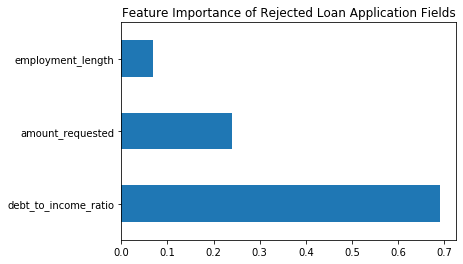

In [772]:
#call the feature Classifier for the rejected and accepted loans
rejectFeatureClassifier = FeatureClassifier(XrejectTypes,Yreject,"Rejected")
acceptFeatureClassifier = FeatureClassifier(XacceptTypes,Yaccept,"Accepted")

In [791]:
import seaborn as sns

0.9.0


In [776]:
def corrFeatures(loan):
    """
        Create list of input variables to be feed into correlation model
    """
    LoanCorr = loan.corr()
    LoanCorrFeatures = LoanCorr.index
    
    return LoanCorrFeatures

In [778]:
rejectedCorrFeatures = corrFeatures(rejected_df)
acceptedCorrFeatures = corrFeatures(accepted_df)

In [779]:
def heatMap(loan, Type, labels, corrFeature, formattedLabel):
    """
        Create heatmap showing correlations between all variables in loan data frame
    """

    #count the number of labels
    pos  = np.arange(len(labels))

    #plot heat map
    g=sns.heatmap(loan[corrFeature].corr(),
                  annot=True, 
                  cmap="coolwarm", 
                  linewidths=.5, 
                  cbar=False, 
                  square=True,
                  xticklabels=False,
                  yticklabels=False,)

    #create the x and y axis, add labels
    plt.xticks(pos, labels, rotation=90, va="center_baseline", ha="center")
    plt.yticks(pos, labels)

    #add title to heatmap
    plt.title(f"{Type} Loan Applications by {formattedLabel}")

    #adjust margins of heatmap and display
    b, t = plt.ylim()
    b += 1.25
    t -= 1.25
    plt.ylim(b, t)
    plt.show()

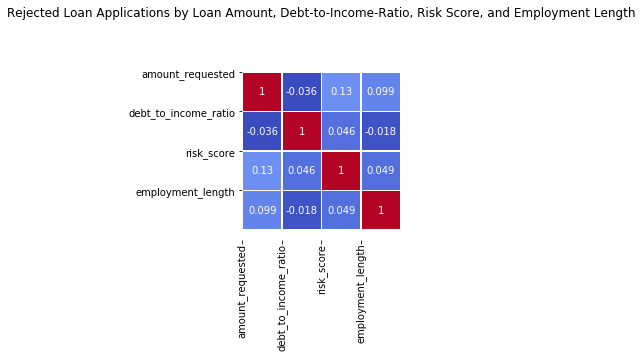

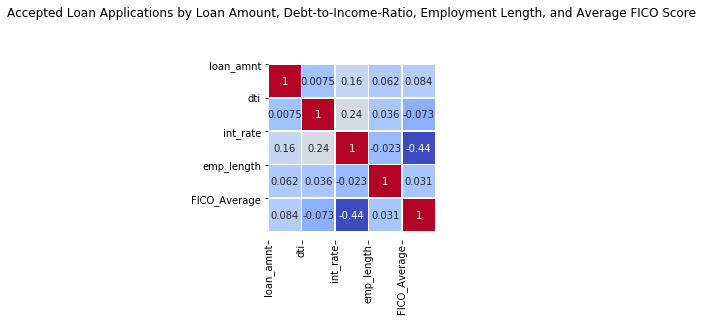

In [780]:
RejectLabels = ['amount_requested', 'debt_to_income_ratio', 'risk_score', 'employment_length']
RejectedLabelsFormatted = 'Loan Amount, Debt-to-Income-Ratio, Risk Score, and Employment Length'

AcceptedLabels = ['loan_amnt', 'dti', 'int_rate', 'emp_length', 'FICO_Average']
AcceptedLabelsFormatted = 'Loan Amount, Debt-to-Income-Ratio, Employment Length, and Average FICO Score'

RejectedHeatMap = heatMap(rejected_df, "Rejected", rejectedCorrFeatures, RejectLabels, RejectedLabelsFormatted)
AcceptedHeatMap = heatMap(accepted_df, "Accepted", acceptedCorrFeatures, AcceptedLabels, AcceptedLabelsFormatted)